In [ ]:
# Import Required Libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# DATASET CONFIGURATION
train_dir = "dataset/training_set"
test_dir = "dataset/test_set"

# IMAGE PARAMETERS
IMG_SIZE = (150, 150)  # Standard size for cats vs dogs
BATCH_SIZE = 32
EPOCHS = 15

In [3]:
# DATA PREPROCESSING & AUGMENTATION
# Enhanced data augmentation for better generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
# TRANSFER LEARNING WITH VGG16 (Replacing Custom CNN)
# We use VGG16 pretrained on ImageNet, remove top, freeze base, and add custom classifier.

initial_learning_rate = 0.0005  # Slightly lower for transfer learning fine-tuning
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=800,
    decay_rate=0.95,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Load VGG16 without top classifier
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze all convolutional layers initially

# Build top classifier
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs, name='vgg16_transfer')

model.summary()

c:\Users\Shane Canabo\Desktop\python_exercises\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,635,905 (13.87 MB)

 Trainable params: 3,634,433 (13.86 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# COMPILE THE MODEL (Transfer Learning)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# OPTIONAL: Later you can unfreeze some deeper layers for fine-tuning:
# for layer in base_model.layers[-4:]:
#     layer.trainable = True
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# TRAIN THE CUSTOM CNN MODEL
print("Starting training...")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    verbose=1
)

print("\nTraining completed!")

Starting training...
Training samples: 6400
Validation samples: 1600
Test samples: 2000
Epoch 1/15
Epoch 1/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.5428 - loss: 1.9895 - val_accuracy: 0.5006 - val_loss: 1.8504
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 291s 1s/step - accuracy: 0.5428 - loss: 1.9895 - val_accuracy: 0.5006 - val_loss: 1.8504
Epoch 2/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 590ms/step - accuracy: 0.5716 - loss: 1.7832 - val_accuracy: 0.5000 - val_loss: 2.0207
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 118s 590ms/step - accuracy: 0.5716 - loss: 1.7832 - val_accuracy: 0.5000 - val_loss: 2.0207
Epoch 3/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 150s 751ms/step - accuracy: 0.6017 - loss: 1.5381 - val_accuracy: 0.6562 - val_loss: 1.3918
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 150s 751ms/step - accuracy: 0.6017 - loss: 1.5381 - val_accuracy: 0.6562 - val_loss: 1.3918
Epoch 4/15
200/200 ━━━━━━━━━━━━━━━━━━━━ 130s 651ms/step - accuracy: 0.6244 - loss: 1.3313 - val_accuracy: 0.6712 - 

In [7]:
# EVALUATE THE MODEL ON TEST SET
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 535ms/step - accuracy: 0.6945 - loss: 0.9225
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 535ms/step - accuracy: 0.6945 - loss: 0.9225

Test Accuracy: 0.6945 (69.45%)
Test Loss: 0.9225

Test Accuracy: 0.6945 (69.45%)
Test Loss: 0.9225


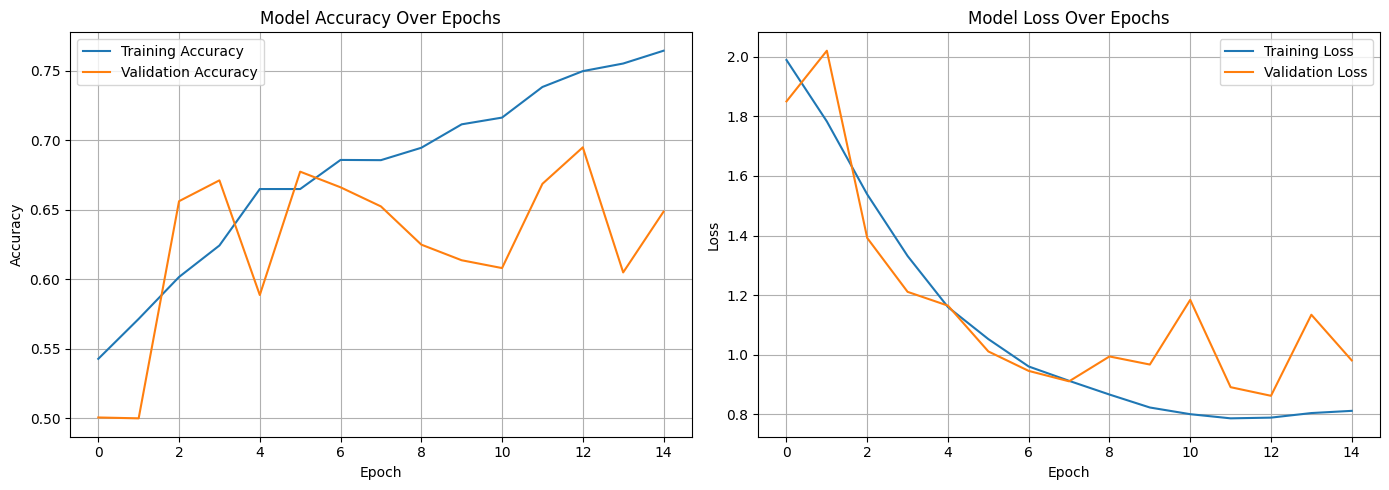

In [8]:
# PLOT TRAINING HISTORY
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# SAVE THE TRANSFER LEARNING MODEL
model.save('exercise_6_custom_canabo_vgg16.h5')
print('Model saved as: exercise_6_custom_canabo_vgg16.h5')

Model saved as: exercise_6_custom_canabo.h5


In [11]:
# PREDICTION FUNCTION
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model_path='exercise_6_custom_canabo.h5'):
    """Predict whether an image is a cat or dog"""
    model = tf.keras.models.load_model(model_path)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array, verbose=0)[0,0]
    
    # Note: Check what class_indices are (0=cats, 1=dogs or vice versa)
    print(f"Class indices: {train_generator.class_indices}")
    
    if pred >= 0.5:
        label = "Dog"
        confidence = pred
    else:
        label = "Cat"
        confidence = 1 - pred
    
    print(f"Image: {img_path}")
    print(f"Prediction: {label}")
    print(f"Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"Raw prediction value: {pred:.4f}")
    return pred

In [12]:
# TEST PREDICTIONS ON SAMPLE IMAGES
print("=" * 70)
print("PREDICTION TEST 1")
print("=" * 70)
predict_image("dataset/single_prediction/cat_or_dog_1.jpg")

print("\n" + "=" * 70)
print("PREDICTION TEST 2")
print("=" * 70)
predict_image("dataset/single_prediction/cat_or_dog_2.jpg")

PREDICTION TEST 1


Class indices: {'cats': 0, 'dogs': 1}
Image: dataset/single_prediction/cat_or_dog_1.jpg
Prediction: Dog
Confidence: 0.7247 (72.47%)
Raw prediction value: 0.7247

PREDICTION TEST 2
Class indices: {'cats': 0, 'dogs': 1}
Image: dataset/single_prediction/cat_or_dog_2.jpg
Prediction: Cat
Confidence: 0.9154 (91.54%)
Raw prediction value: 0.0846
Class indices: {'cats': 0, 'dogs': 1}
Image: dataset/single_prediction/cat_or_dog_2.jpg
Prediction: Cat
Confidence: 0.9154 (91.54%)
Raw prediction value: 0.0846


np.float32(0.084639035)

## Model Architecture Summary (Updated: VGG16 Transfer Learning)

### Why VGG16?
VGG16 is a strong baseline for binary image classification (cats vs dogs) due to:
- Simple, well-understood architecture (stacked 3x3 convolutions)
- Pretrained ImageNet weights capture general features transferable to pet images
- Lower complexity vs Inception/ResNet for faster experimentation on limited hardware
ResNet and Inception can outperform VGG16 on large datasets, but they are deeper/more complex. For moderate-sized datasets and quick adaptation, VGG16 offers a good balance of accuracy, speed, and simplicity.

### Modifications Applied:
1. Used `VGG16(include_top=False, weights='imagenet')` as frozen feature extractor
2. Added Global Average Pooling instead of Flatten to reduce parameters
3. Added Dense(256) + Dense(128) with L2 regularization and Dropout(0.5) for generalization
4. Learning rate decay schedule + Adam optimizer
5. Option commented to unfreeze last layers for fine-tuning later

### Transfer Learning Benefits:
- Faster convergence
- Reduced overfitting compared to training from scratch
- Leverages rich pretrained feature hierarchy

### Next Steps (Optional):
- Unfreeze last 2–4 convolutional blocks and fine-tune with lower LR (1e-5)
- Add class-weighting if imbalance exists
- Try ResNet50 for comparison once baseline is stable
